In [179]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_context('talk', font_scale=2)
sns.set_style('white')


Populating the interactive namespace from numpy and matplotlib


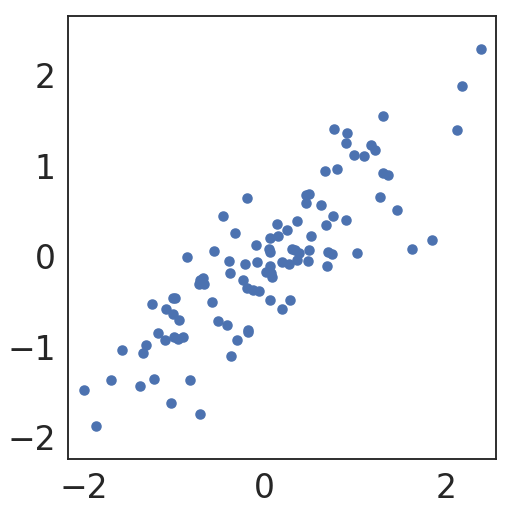

In [180]:
np.random.seed(42)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 100)).T
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1])
ax.axis('equal')
fig.tight_layout()


In [232]:
def draw_vector(v0, v1, ax=None, linestyle='-'):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    linestyle=linestyle,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops, clip_on=False)


In [182]:
pca = PCA(n_components=2)
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [183]:
pca.explained_variance_

array([1.40229073, 0.11393355])

In [184]:
pca.mean_

array([ 0.01906202, -0.06685873])

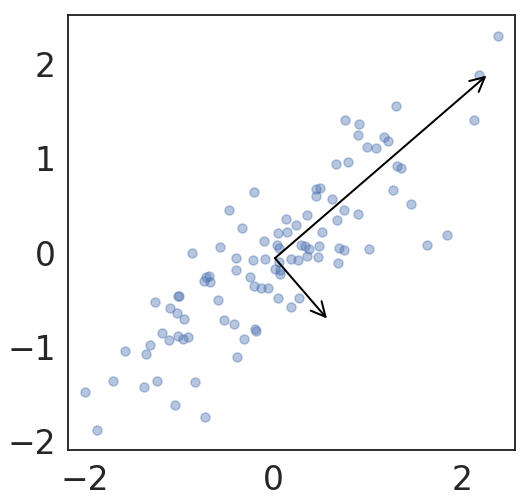

In [185]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], alpha=0.4)
original_vectors = []
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2.5 * np.sqrt(length)
    original_vectors.append((pca.mean_, pca.mean_ + v))
    draw_vector(pca.mean_, pca.mean_ + v, ax, '-')
plt.axis('equal');

# Add outliers

In [253]:
np.random.seed(42)
X_normal = np.dot(np.random.rand(2, 2), np.random.randn(2, 100)).T
X_outlier1 = np.random.normal(loc=-0.5, scale=1, size=(1,2))*2.5 + np.array([2, 9])
X_outlier2 = np.random.normal(loc=0.5, scale=1, size=(1,2))*2.5 + np.array([-2, -9])
X_outlier3 = np.random.normal(loc=0.5, scale=1, size=(1,2))*5 + np.array([-2, -9])

In [254]:
X = np.vstack([X_normal, X_outlier1, X_outlier2, X_outlier3])

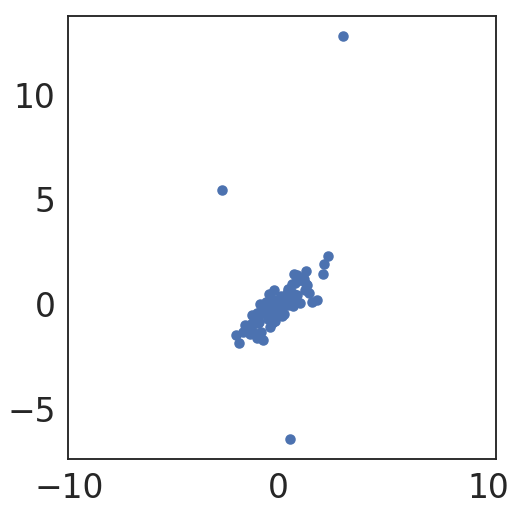

In [255]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1])
ax.axis('equal')
fig.tight_layout()


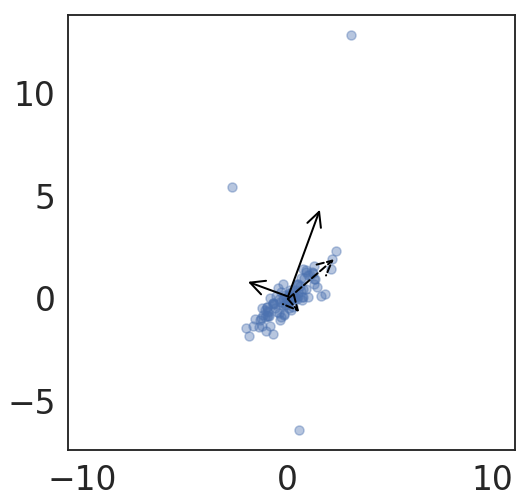

In [256]:
pca = PCA(n_components=2)
pca.fit(X)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], alpha=0.4)

for index, (length, vector) in enumerate(zip(pca.explained_variance_, pca.components_)):
    v = vector * 2.5 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax)
    draw_vector(original_vectors[index][0], original_vectors[index][1], ax, '--')
plt.axis('equal');

# Robust PCA

In [234]:
class RPCA:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [235]:
rpca = RPCA(X)
L, S = rpca.fit(max_iter=10000, iter_print=100)


iteration: 1, error: 16.260149859203608
iteration: 67, error: 5.692087430739036e-06


0
1


(-2.9260366230972976, 2.106084009120373, -7.077908469514768, 6.017810747007484)

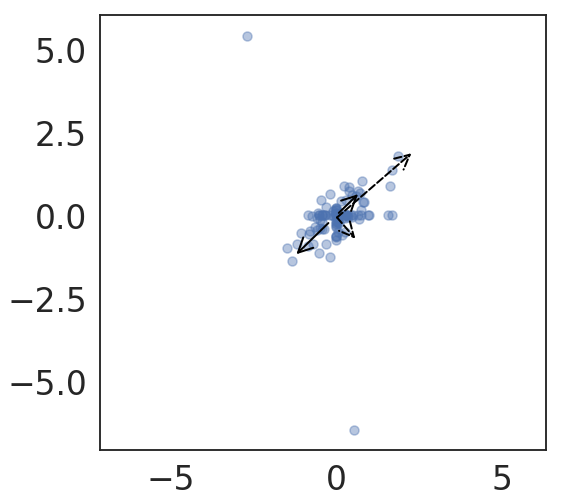

In [246]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(S[:, 0], S[:, 1], alpha=0.4, clip_on=False)
for index in range(2):
    print(index)
    draw_vector(original_vectors[index][0], original_vectors[index][1], ax, '--')

draw_vector(L[0], L[0]*5, ax, '-')
draw_vector(L[1], L[1]*9, ax, '-')
ax.axis('equal')

In [247]:
S.shape

(102, 2)

In [245]:
np.dot(L[0], L[0].T)

0.1131360783519754

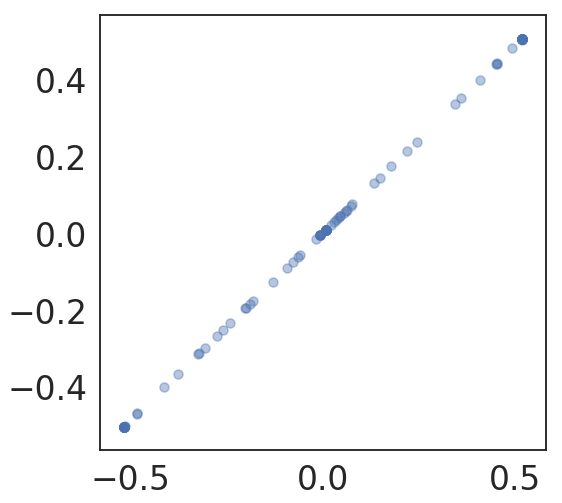

In [257]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(L[:, 0], L[:, 1], alpha=0.4, clip_on=False)